# Automarrow - os coxae

mailto:johbla@ous-hf.no

The os coxae seems to be the most promissing region to do red marrow dose-toxicity-analysis on

It is somewhat time-consuming to draw, and maybe a semi-automated technique is better?

Previous work (where alot of ugly methods has been written) has focused on the lumbar vertebrae - but the os coxae has a bit more distinct perenost, and lacking a spinal canal. Maybe it is more simple to segment?

### 27/6/2018
The last time I worked with this was last year - now I have learned a lot of better techniques to read and write dicom-files - but that I can integrate later. Focus on the segmentation.

It seems that some pre-processing is required. First attempt does not look too shabby. The tuning points is the threshold value (no shit!) and the region that is the right (radiology-left) hip-bone. For slice ```z = 230 ```I have sucessfully segmented the right region with ```threshold = np.mean(img)*4.4``` and ```single_label_image[label_image == 6] = 1```

An idea I have to write in a todo now: Use the previous region to guess the next OR use symmetry and pick the left one (could be bad as some structures are on center)

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from chan_vese_src import chan_vese
import skimage.morphology as sm
import skimage.measure as sme


(512L, 512L, 492L)


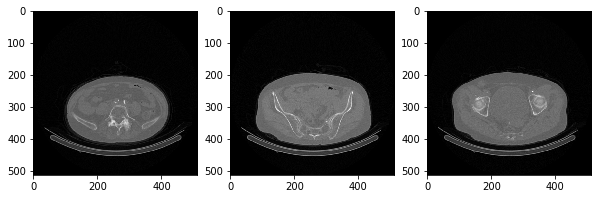

In [14]:
(ct_stack, z_val_vec) = np.load("test.npy")

print ct_stack.shape

fig, (ax0, ax1, ax2) = plt.subplots(nrows = 1, ncols=3, figsize = (10,4))

ax0.imshow(ct_stack[:,:,230], cmap='gray')
ax1.imshow(ct_stack[:,:,270], cmap='gray')
ax2.imshow(ct_stack[:,:,300], cmap='gray')

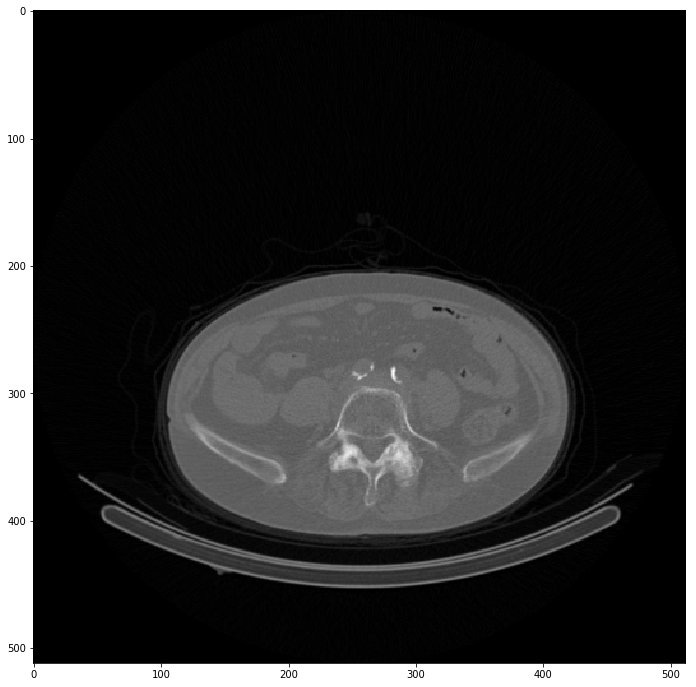

In [17]:
# Now lets do the one @ z = 230

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize = (12,12))
ax0.imshow(ct_stack[:,:,230], cmap="gray")

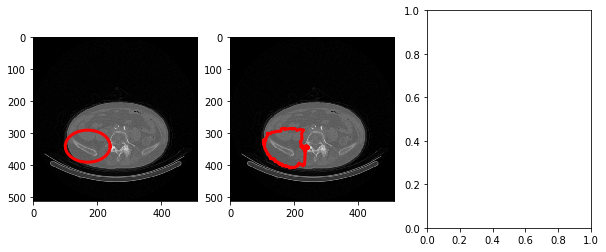

In [51]:
# Follow the set in main.py with the snake or the chan-vese approach (used Sambuceti et. al PET/CT meassurements of bone marrow 
# marrow volume)

# Starting with snake as it passes the test

img = ct_stack[:,:,230]#/np.max(ct_stack[:,:,230])

# The initial curve:

s = np.linspace(0, 2*np.pi, 400)
x = 170 + 70*np.cos(s)
y = 340 + 50*np.sin(s)

init = np.array([x,y]).T

snake = active_contour(gaussian(img, 3),
                       init,
                       alpha = 0.015,
                       beta = 10,
                       gamma = 0.001)

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (10,4))
ax0.imshow(img, cmap="gray")
ax0.plot(init[:,0], init[:,1], 'r', lw = 3)
ax1.imshow(img, cmap="gray")
ax1.plot(snake[:,0], snake[:,1], 'r', lw = 3)
plt.show()

In [144]:

# Thresholding seems to work quite well
# Can now reformat into a function - good to do it right away

img = ct_stack[:,:,230]

def pre_threshold(img, threshold_tuning = 4.4, do_plot = False, label = 6, pass_prev_mask = False, prev_mask = None):
    
    

    threshold = np.mean(img)*threshold_tuning

    mask = np.zeros(img.shape)
    mask[img>threshold] = 1

    # After threshold - remove "salt" and close the image

    open_image = sm.binary_opening(mask)
    closed_image = sm.binary_closing(open_image)

    # Now the image can be labeled so we only keep the region we are interested in

    label_image = sme.label(closed_image)
    single_label_image = np.zeros(label_image.shape)
    
    if pass_prev_mask:
        
        print "Previous mask passed, finding overlapping label "
        
        result_image = np.logical_and(prev_mask, label_image)
        label_final = np.unique(label_image[result_image])
        
        if len(label_final) == 1:
            
            label_final = int(label_final)
            
        else:
            
            print label_final
        
    else:
        
        print "Using passed label instead"
        label_final = label
        
    print label_final
    
    single_label_image[label_image == label_final] = 1

    # Binary close the final image

    binary_closed_second = sm.binary_closing(single_label_image, selem=np.ones([10,10]))
    
    if do_plot:

        fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
        ax0.imshow(img, cmap="gray")
        ax1.imshow(mask, cmap="gray")
        ax2.imshow(open_image, cmap="gray")

        fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
        ax0.imshow(closed_image, cmap="gray")
        ax1.imshow(label_image, cmap="spectral_r")
        ax2.imshow(single_label_image, cmap="gray")

        fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
        ax0.imshow(img, cmap="gray")
        ax0.imshow(binary_closed_second, cmap="Blues", alpha=0.5)
        #ax1.imshow(label_image, cmap="spectral_r")
        #ax2.imshow(binary_closed_second, cmap="gray")

        plt.show()
    
    return (binary_closed_second, label_image)
    


Using passed label instead
6
Previous mask passed, finding overlapping label 
4
Previous mask passed, finding overlapping label 
3
Previous mask passed, finding overlapping label 
6
Previous mask passed, finding overlapping label 
8
Previous mask passed, finding overlapping label 
7
Previous mask passed, finding overlapping label 
[6 7 8]
[6 7 8]


C:\Users\JB\Anaconda2\lib\site-packages\ipykernel_launcher.py:48: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


TypeError: only size-1 arrays can be converted to Python scalars

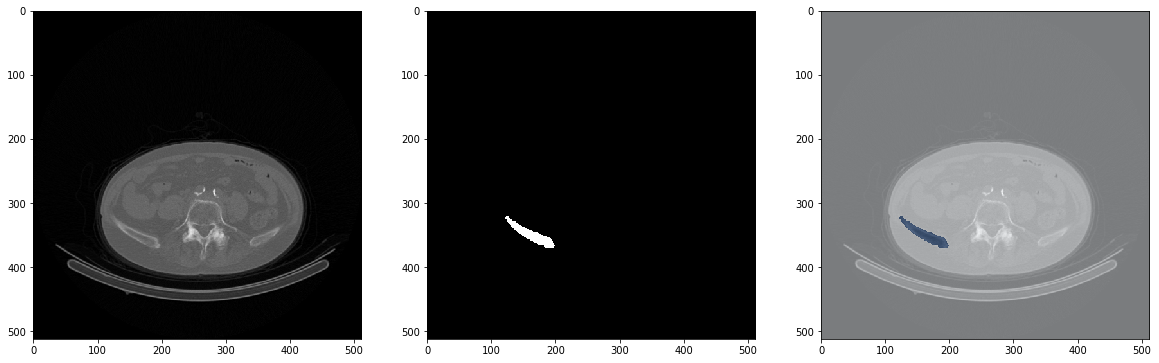

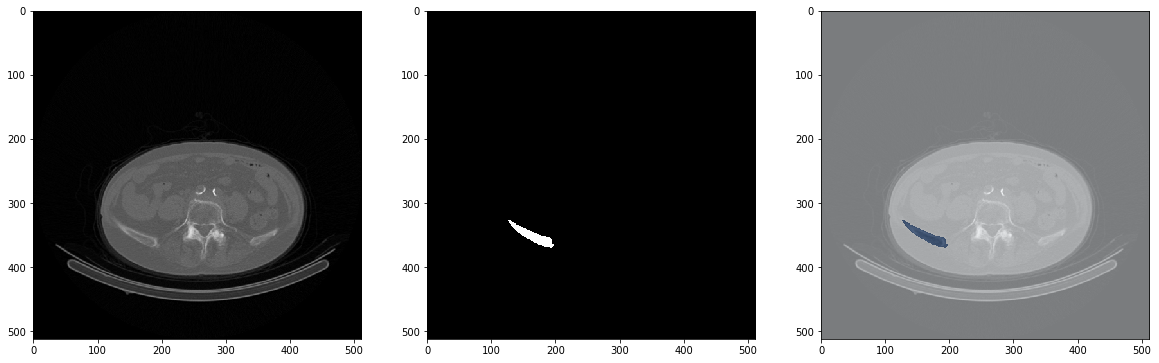

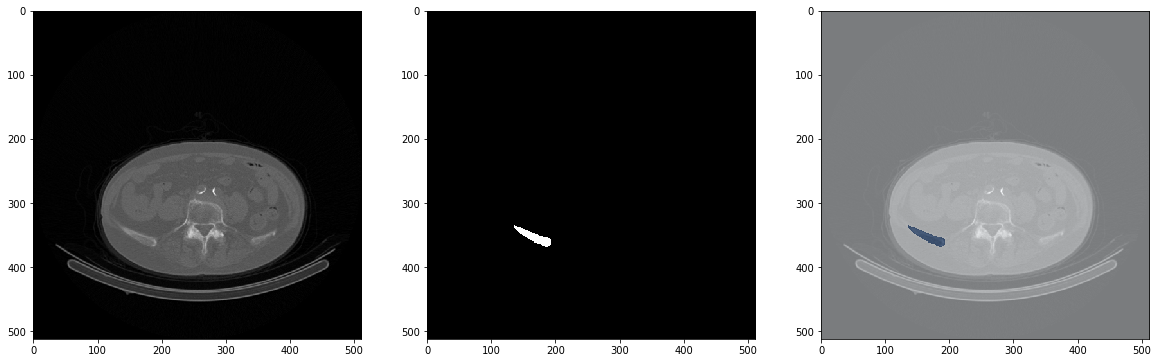

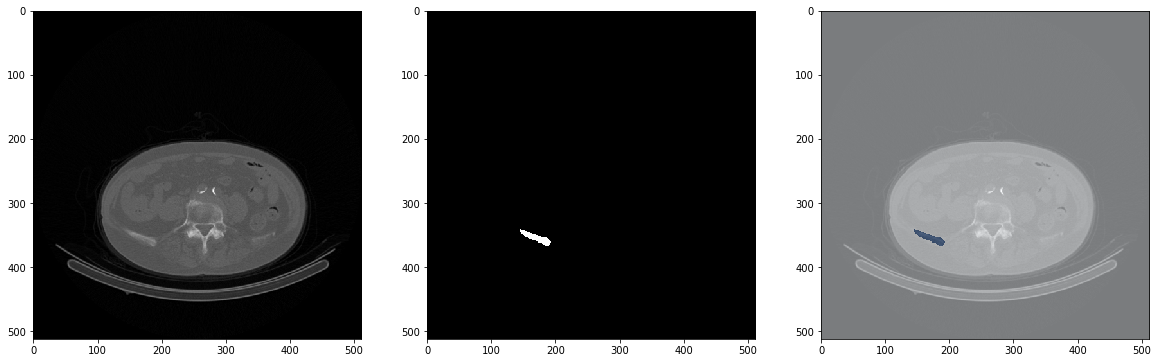

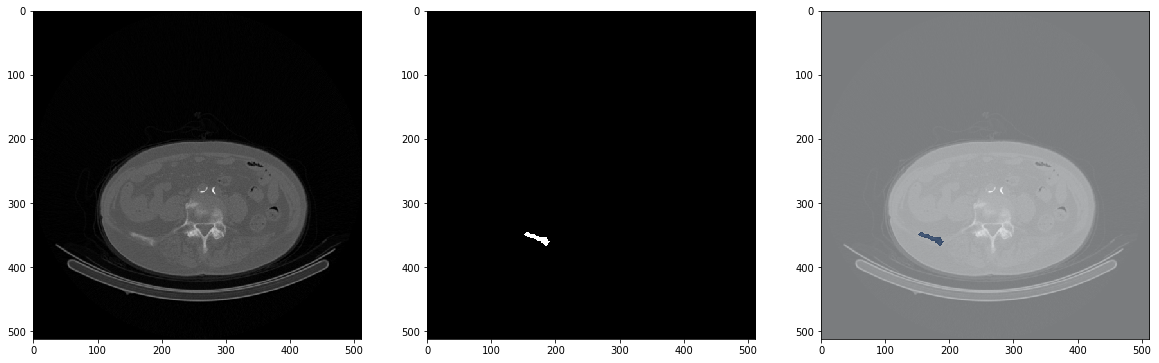

In [145]:


(pre_image_mask, label_image) = pre_threshold(img, label = 6)


for i in range(10):

    img2 = ct_stack[:,:,229-i]

    (pre_image, label_image) = pre_threshold(img2, pass_prev_mask = True, prev_mask=pre_image_mask)

    # Normalize the label_image and and-it

    label_image_norm = label_image/np.max(label_image)
    result_image = np.logical_and(pre_image, label_image)
    label = int(np.unique(label_image[result_image]))

    #print np.min(label_image_norm)


    #fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
    #ax0.imshow(img, cmap="gray")
    #ax1.imshow(pre_image, cmap="gray")
    #ax2.imshow(img, cmap="gray")
    #ax2.imshow(pre_image, cmap="Blues", alpha=0.5)

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
    ax0.imshow(img2, cmap="gray")
    ax1.imshow(pre_image, cmap="gray")
    ax2.imshow(img2, cmap="gray")
    ax2.imshow(pre_image, cmap="Blues", alpha=0.5)